<a href="https://colab.research.google.com/github/satvik-dixit/feature_importance/blob/main/FI_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Importance in Speech Emotion Recognition

A demo for caluculating the feauture importance in speech emotion recoginition using the CREMA-D dataset. We try to see which of the 88 features in openSMILE egemaps are the most important for classifying anger Vs neutral. The demo has been divided into 3 phases:
- Phase 1: Loading audio files and extracting metadata
- Phase 2: Embedding Extraction
- Phase 3: Downstream Task - Speech Emotion Recognotion
- Phase 4: Getting Recall for classifying anger vs neutral
- Phase 5: Feature Importance
  - Precision Importance
  - Standard methods
  

### Importing packages

In [ ]:
!git clone -q https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -q -e ./serab-byols

!pip install -q tqdm==4.60.0
!pip install -q opensmile

     |████████████████████████████████| 75 kB 3.2 MB/s 
     |████████████████████████████████| 4.5 MB 14.4 MB/s 
     |████████████████████████████████| 635 kB 61.9 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 167 kB 56.4 MB/s 


In [ ]:
# code to restart runtime so the packages get installed
import os
os.kill(os.getpid(), 9)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample

import librosa
import soundfile as sf

import torch
import opensmile
import serab_byols

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

# Name directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


### About CREMA-D:
- A German database of emotional speech
- 800 recordings
- 10 actors (5 males and 5 females)
- 7 emotions: anger, neutral, fear, boredom, happiness, sadness, disgust

### References:
- Dataset: http://emodb.bilderbar.info/index-1280.html
- Paper: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.130.8506&rep=rep1&type=pdf




# Phase 1: Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [ ]:
# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))
      
  return audio_list
        

### Loading and resampling audiofiles and collecting metadata on CREMA-D dataset

In [ ]:
# Phase_1
# Load dataset
! kaggle datasets download -q -d ejlok1/cremad
! unzip -q cremad.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/AudioWAV','*.wav'))
audio_list = load_audio_files(audio_files, resampling_frequency=16000)

# Make speakers list and labels list 
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:4]))
  labels.append(file_name[9:12])


# Verify phase_1
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))

Number of audio files: 7442
Number of speaker classes: 91
Speaker classes: {1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023}
Number of speakers: 7442
Number of label classes: 6
Label classes: {'FEA', 'SAD', 'HAP', 'ANG', 'DIS', 'NEU'}
Number of labels: 7442


# Phase 2: Embedding Extraction
Includes extracting features using openSMILE egemaps

### Audio embeddings extraction functions

In [ ]:

def get_egemaps_feature_names():
  model = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  egemaps_feature_names = model.column_names
  return egemaps_feature_names


# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
  '''
  Generates model for embedding extraction 
  
  Parameters
  ------------
  mode_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

  Returns
  ------------
  model: object
      The embedding extraction model
  '''
  if model_name=='hybrid_byols':
    model_name = 'cvt'
    checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
    model = serab_byols.load_model(checkpoint_path, model_name)
  elif model_name=='compare':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  elif model_name=='egemaps':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_list: list
      A list of arrays, one array for each audio file
  model_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
  model: object
      The embedding extraction model generated by audio_embeddings_model function
  sampling_rate: int
      The sampling rate, 16 kHz by default

  Returns
  ------------
  embeddings_array: array
      The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  if model_name=='hybrid_byols':
    embeddings_array = serab_byols.get_scene_embeddings(audio_list, model)
  else:
    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
      embeddings = model.process_signal(audio_list[i], sampling_rate)
      embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
  return embeddings_array


### Audio embeddings extraction on CREMA-D

In [ ]:
# CREMA-D egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)
egemaps_feature_names = get_egemaps_feature_names()

# ---------------------------------------------------------------------------------------------------

# Verify Phase_2
models = ['egemaps']
embeddings_arrays = {'egemaps':embeddings_array_egemaps}

print(egemaps_feature_names)

for model in models:
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))
  print('The embeddings array is: ')
  print((embeddings_arrays[model]))


100%|██████████| 7442/7442 [08:48<00:00, 14.07it/s]


['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mfcc4_sma3_std

# Phase 3: Pre-Processing
Includes:
- Speaker Normalisation
- Label Division

### Speaker normalisation functions

In [ ]:
# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  speaker_ids = set(speakers)
  for speaker_id in speaker_ids:
    speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
    speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
    scaler = StandardScaler()
    normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
    embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
  return embeddings_array


### Speaker normalisation on CREMA-D

In [ ]:
# Normalised arrays
normalised_embeddings_egemaps = speaker_normalisation(embeddings_array_egemaps, speakers)


# Verifying normalised_embeddings_arrays
normalised_embeddings_arrays = {'egemaps':normalised_embeddings_egemaps}

for model in models:

  print('MODEL: {}'.format(model))
  print()
  print('The shape of the normalised embeddings array is: {}'.format(normalised_embeddings_arrays[model].shape))
  print('Normalised Embeddings Array:')
  print((normalised_embeddings_arrays[model]))
  columnwise_mean = torch.mean(normalised_embeddings_arrays[model], 0)
  if torch.all(columnwise_mean < 10**(-6)):
    print('PASSED: All means are less than 10**-6')
  else:
    print('FAILED: All means are NOT less than 10**-6')


MODEL: egemaps

The shape of the normalised embeddings array is: torch.Size([7442, 88])
Normalised Embeddings Array:
tensor([[-1.4240e+00,  1.7745e+00, -2.0161e+00,  ..., -2.6010e-01,
          1.8682e-01, -2.1335e-01],
        [-1.2654e+00, -8.9723e-01, -9.6528e-01,  ...,  9.7456e-01,
          4.7602e-01, -9.6101e-01],
        [ 5.8888e-01, -8.7412e-01,  7.2600e-01,  ...,  1.7706e-01,
          1.9299e-03, -2.8167e-01],
        ...,
        [ 2.8904e-01, -7.3343e-01,  3.8555e-01,  ..., -8.4442e-02,
          4.3448e-01,  3.0644e-01],
        [-1.3583e+00,  1.9631e+00, -1.9116e+00,  ..., -1.4887e-01,
         -5.7137e-01, -6.1327e-01],
        [-1.1059e+00,  1.0637e+00, -4.3886e-01,  ..., -4.7625e-02,
         -1.6294e+00, -1.3371e+00]])
PASSED: All means are less than 10**-6


### Label Division

In [ ]:
# Defining a function for selecting a part of the dataset containing only the required labels

def label_division(embeddings_array, labels, required_labels, speakers):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  final_embeddings_array = {}
  final_labels_list = {}
  final_speakers_list = []
  for label in required_labels:
    # print(label)
    label_indices = np.where(np.array(labels)==label)[0]
    # print(label_indices)
    label_embeddings = embeddings_array[label_indices,:]
    # print(label_embeddings.shape)
    final_speakers_list.extend(list(np.array(speakers)[label_indices]))
    final_embeddings_array[label] = label_embeddings
    final_labels_list[label] = [label]*len(label_indices)
    # print(final_labels_list[label])
  final_embeddings = np.vstack((final_embeddings_array[required_labels[0]], final_embeddings_array[required_labels[1]]))
  final_labels = final_labels_list[required_labels[0]]+final_labels_list[required_labels[1]]
  # print(final_embeddings.shape)
  # print(len(final_labels))
  # print(len(final_speakers_list))
  # print(final_speakers_list)
  return final_embeddings, final_labels, final_speakers_list


### Label Division on CREMA-D

In [ ]:
labeled_array_egemaps, labels_list_egemaps, labeled_speakers_list = label_division(normalised_embeddings_egemaps, labels, ['NEU', 'ANG'], speakers)
# labeled_array_byols, labels_list_byols = label_division(normalised_embeddings_byols, labels, ['NEU', 'ANG'])
# labeled_array_compare, labels_list_compare = label_division(normalised_embeddings_compare, labels, ['NEU', 'ANG'])

# labeled_array_egemaps, labels_list_egemaps = label_division(normalised_embeddings_egemaps, labels, ['N', 'A'])
# labeled_array_byols, labels_list_byols = label_division(normalised_embeddings_byols, labels, ['N', 'A'])
# labeled_array_compare, labels_list_compare = label_division(normalised_embeddings_compare, labels, ['N', 'A'])


# Verify Label Division

labeled_arrays = {'egemaps': labeled_array_egemaps}
label_lists = {'egemaps': labels_list_egemaps}
print(labeled_array_egemaps)
print()
print(labels_list_egemaps)
print()
print(labeled_speakers_list)

[[-1.4240040e+00  1.7745140e+00 -2.0160594e+00 ... -2.6009732e-01
   1.8682285e-01 -2.1334849e-01]
 [ 5.8888471e-01 -8.7412125e-01  7.2599542e-01 ...  1.7705570e-01
   1.9299347e-03 -2.8166863e-01]
 [-6.7415729e-02  2.6638887e+00 -3.5924327e-01 ... -6.8681920e-01
  -7.8626031e-01 -1.7598438e-01]
 ...
 [ 6.3121957e-01 -1.1503523e-01  6.1881423e-01 ... -1.1873817e+00
  -1.2844796e+00  1.4430032e+00]
 [ 8.9306509e-01  1.4142219e+00  1.0249767e+00 ... -1.1182894e+00
  -1.0862955e+00  1.3628304e+00]
 [ 1.1382126e+00 -4.7384641e-01  1.2678561e+00 ... -2.8869179e-01
   9.6256357e-01  1.3708702e+00]]

['NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU', 'NEU',

# Getting Recall (Emotion Vs Neutral)

In [ ]:
# Defining a function for splitting into train set and test set with diferent speakers in each set
def split_train_test(normalised_embeddings_array, labels, speakers, test_size = 0.30):
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  normalised_embeddings_array: torch tensor
    The tensor containing normalised embeddings 
  labels: list of strings
    The list of emotions corresponding to audio files
  speakers: list 
    The list of speakers
  test_size: float 
    The fraction of embeddings and labels to put in the test set

  Returns
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
   The labels that will be used for training
  y_test: list
   The labels that will be used for testing

  '''
  # unique speakers in this dataset
  all_speakers = set(speakers)
  # unique speakers in test set
  test_speakers = sample(all_speakers, int(test_size*len(all_speakers)))

  test_speakers_indices = []
  train_speakers_indices = []

  for speaker in all_speakers:
      if speaker in test_speakers:
          speaker_indices = np.where(np.array(speakers)==speaker)[0]
          test_speakers_indices.extend(speaker_indices)
      else:
          speaker_indices = np.where(np.array(speakers)==speaker)[0]
          train_speakers_indices.extend(speaker_indices)

  X_train = normalised_embeddings_array[train_speakers_indices]
  X_test = normalised_embeddings_array[test_speakers_indices]

  y_train = [0 for i in range(len(train_speakers_indices))]
  y_test = [0 for i in range(len(test_speakers_indices))]

  for i,index in enumerate(train_speakers_indices):
      y_train[i] = labels[index]
  for i,index in enumerate(test_speakers_indices):
      y_test[i] = labels[index]

  return X_train, X_test, y_train, y_test


# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters):
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
    The labels that will be used for training
  y_test: list
    The labels that will be used for testing
  classifier: object
    The instance of the classification model 
  parameters: dictionary
    The dictionary of parameters for GridSearchCV 

  Returns
  ------------
    The dictionary of the best hyperparameters
  
  '''
  grid = GridSearchCV(classifier, param_grid = parameters, cv=5, scoring='recall_macro')                     
  grid.fit(X_train,y_train)
  # print('recall_macro :',grid.best_score_)
  # print('Best Parameters: {}'.format(grid.best_params_))
  print('recall_macro on test_set: {}'.format(grid.score(X_test, y_test)))
  predictions = grid.predict(X_test)
  # print(classification_report(y_test, predictions))
  return grid.score(X_test, y_test)

In [ ]:
# Defining a function for all steps 
def pipeline(labeled_array, speakers, labels_list, classification_model):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''

  # print('MODEL: {}'.format(model_name))

  # Train Test Splitting
  X_train, X_test, y_train, y_test = split_train_test(
      labeled_array, labels_list, speakers, test_size=0.30)
  # print('X_train shape: {}'.format(X_train.shape))
  # print('X_test shape: {}'.format(X_test.shape))
  # print('y_train len: {}'.format(len(y_train)))
  # print('y_test len: {}'.format(len(y_test)))
  # print()

  # Getting hyperparameters and checking max_recall
  if classification_model == 'logreg':
    classifier = LogisticRegression()
    parameters = {'penalty' : ['l1', 'l2'], 'C': np.logspace(-3,1,3), 'solver': ['lbfgs', 'sag']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  elif classification_model == 'svm':
    classifier = SVC()
    parameters = {'C': np.logspace(-2,4,4), 'gamma': np.logspace(-5,-3,5), 'kernel':['rbf']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  elif classification_model == 'rf':
    classifier = RandomForestClassifier()
    parameters = {'n_estimators' : [50, 100, 200], 'max_features' : ['auto', 'log2', 'sqrt'], 'bootstrap' : [False]}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  return result


In [ ]:
pipeline(labeled_array_egemaps, labeled_speakers_list, labels_list_egemaps, classification_model='logreg')

recall_macro on test_set: 0.9542378727283178


0.9542378727283178

# Feature Importance

## Method 1: permutation_importance

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
color='#FF3030'

def permutation_importance_method(X, y, feature_names, color, top_ten=False, plot=True):
  model = KNeighborsClassifier()
  avg_importance = np.zeros((10, 88))

  model.fit(X, y)
  results = permutation_importance(model, X, y, scoring='accuracy', n_repeats=10)
  importance = results.importances_mean

  # print(importance.shape)
  actual_importance = importance
  sorted_importance = sorted(importance)
  sorted_feature_names = []
  for imp_val in sorted_importance:
    for i in range(len(actual_importance)):
      if actual_importance[i] == imp_val:
        sorted_feature_names.append(feature_names[i])
        break
  # print(sorted_feature_names)
  # print(len(sorted_feature_names))
  # print(egemaps_feature_names)
  # print(len(egemaps_feature_names))

  if plot==True:
    if (top_ten==True):
      fig, ax = plt.subplots(figsize=(12, 4))
      bars = ax.barh(sorted_feature_names[-10:], sorted_importance[-10:], color=color)
      print(sorted_feature_names[-10:])
    else:
      fig, ax = plt.subplots(figsize=(12, 20))
      bars = ax.barh(sorted_feature_names, sorted_importance, color=color)

  return importance


### Models: Logistic Regression + SVM + Random Forest Classifier

<function permutation_importance at 0x7f89ebe070e0>


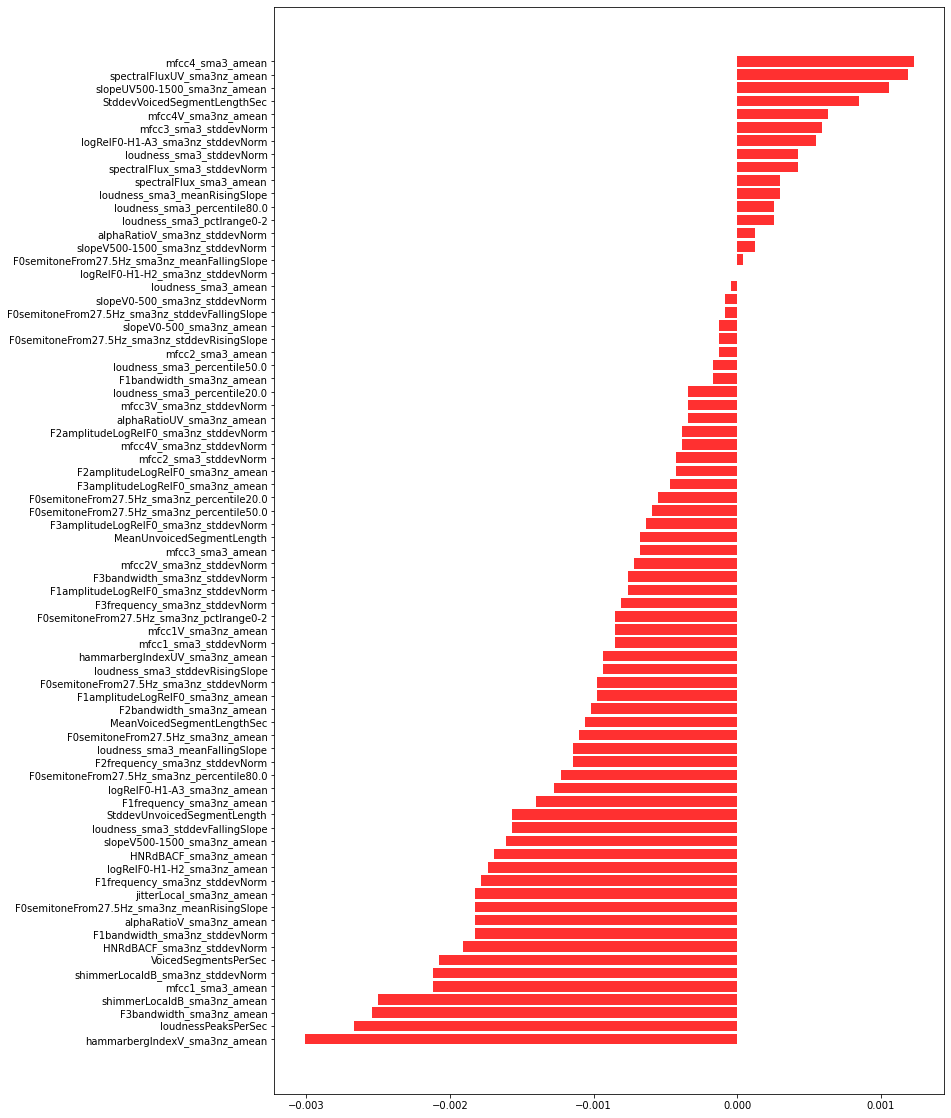

In [ ]:
permutation_importance_method(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color, top_ten=False, plot=True)
print(permutation_importance)


['slopeV500-1500_sma3nz_stddevNorm', 'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc4_sma3_amean', 'alphaRatioV_sma3nz_stddevNorm', 'spectralFluxUV_sma3nz_amean', 'loudness_sma3_stddevNorm', 'slopeUV500-1500_sma3nz_amean', 'mfcc3_sma3_stddevNorm', 'spectralFluxV_sma3nz_stddevNorm', 'spectralFlux_sma3_stddevNorm']
<function permutation_importance at 0x7f89ebe070e0>


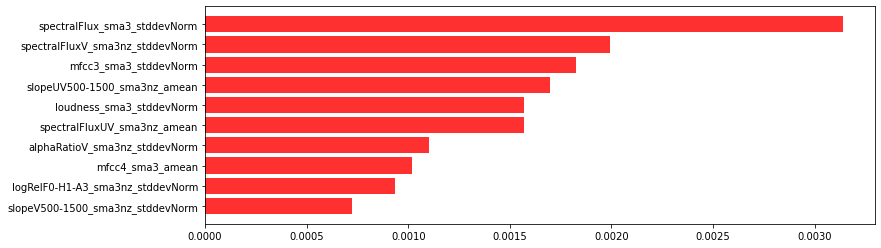

In [ ]:
permutation_importance_method(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color, top_ten=True, plot=True)
print(permutation_importance)


## Method 2: Standard Methods

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Method 2a: Logistic Regression

In [ ]:
from matplotlib import pyplot as plt

def coef_logreg_plot(labeled_array, label_list, feature_names, color, top_ten=False, plot=True):

  classifier = LogisticRegression()

  avg_importance = np.zeros((10, 88))
  for i in range(10):
    classifier.fit(labeled_arrays[model], label_lists[model])
    importance = classifier.coef_
    avg_importance[i] = importance[0]
  importance = np.absolute(np.mean(avg_importance, axis=0))
  importance = NormalizeData(importance)

  actual_importance = importance
  sorted_importance = sorted(importance)
  sorted_feature_names = []
  for imp_val in sorted_importance:
    for i in range(len(actual_importance)):
      if actual_importance[i] == imp_val:
        sorted_feature_names.append(feature_names[i])
        break
  # print(sorted_feature_names)
  # print(len(sorted_feature_names))
  # print(egemaps_feature_names)
  # print(len(egemaps_feature_names))
  if plot==True:
    if (top_ten==True):
      fig, ax = plt.subplots(figsize=(12, 4))
      bars = ax.barh(sorted_feature_names[-10:], sorted_importance[-10:], color=color)
      print(sorted_feature_names[-10:])
    else:
      fig, ax = plt.subplots(figsize=(12, 20))
      bars = ax.barh(sorted_feature_names, sorted_importance, color=color)

  return importance

LOGISTIC REGRESSION


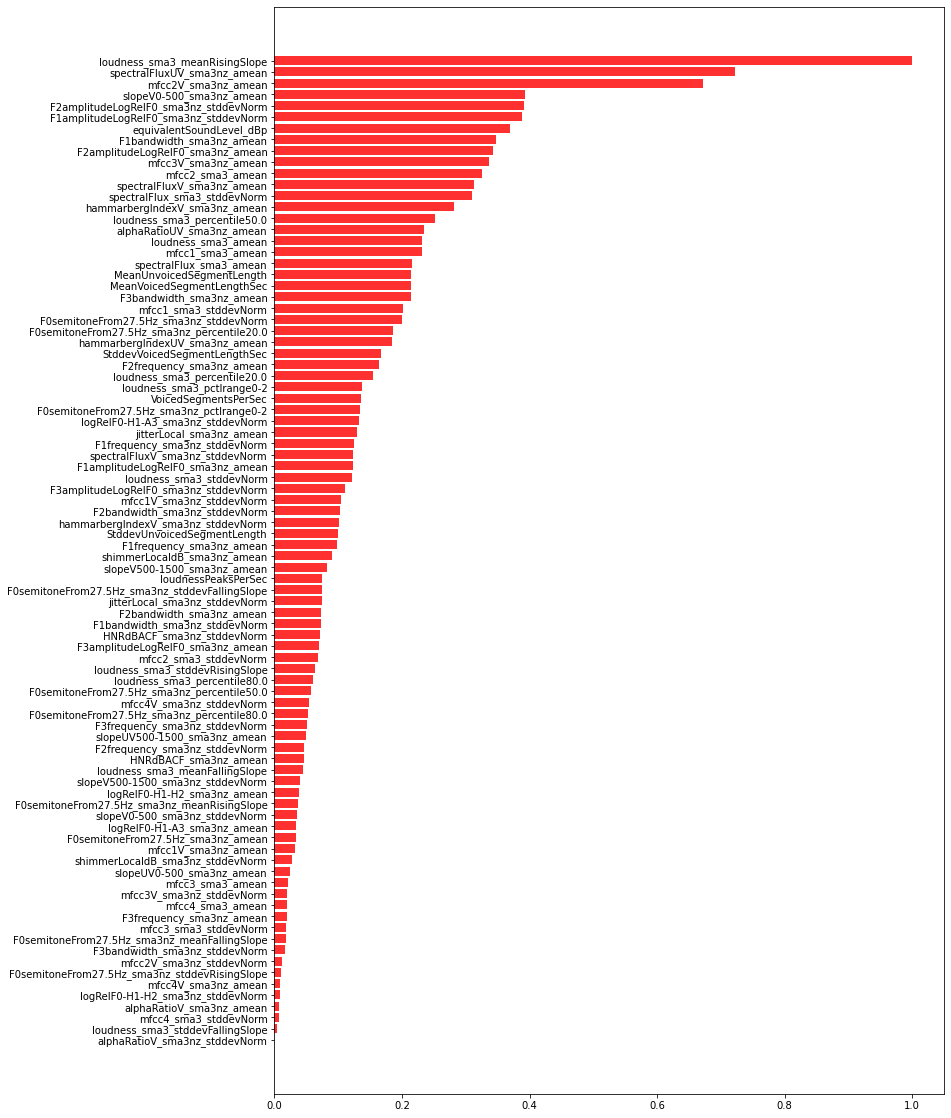

In [ ]:
coef_logreg_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color)
print('LOGISTIC REGRESSION')

['mfcc3V_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_amean', 'F1bandwidth_sma3nz_amean', 'equivalentSoundLevel_dBp', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'slopeV0-500_sma3nz_amean', 'mfcc2V_sma3nz_amean', 'spectralFluxUV_sma3nz_amean', 'loudness_sma3_meanRisingSlope']
LOGISTIC REGRESSION


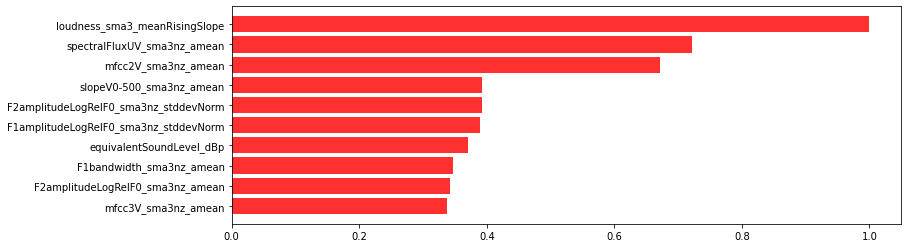

In [ ]:
coef_logreg_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color, top_ten=True)
print('LOGISTIC REGRESSION')

### Method 2b: SVM

In [ ]:

def coef_svm_plot(labeled_array, label_list, feature_names, color, top_ten=False, plot=True):

  classifier = SVC(kernel='linear')

  avg_importance = np.zeros((10, 88))
  for i in range(10):
    classifier.fit(labeled_arrays[model], label_lists[model])
    importance = classifier.coef_
    avg_importance[i] = importance[0]
  importance = np.absolute(np.mean(avg_importance, axis=0))
  importance = NormalizeData(importance)

  actual_importance = importance
  sorted_importance = sorted(importance)
  sorted_feature_names = []
  for imp_val in sorted_importance:
    for i in range(len(actual_importance)):
      if actual_importance[i] == imp_val:
        sorted_feature_names.append(feature_names[i])
        break
  # print(sorted_feature_names)
  # print(len(sorted_feature_names))
  # print(egemaps_feature_names)
  # print(len(egemaps_feature_names))
  if plot==True:
    if (top_ten==True):
      fig, ax = plt.subplots(figsize=(12, 4))
      bars = ax.barh(sorted_feature_names[-10:], sorted_importance[-10:], color=color)
      print(sorted_feature_names[-10:])
    else:
      fig, ax = plt.subplots(figsize=(12, 20))
      bars = ax.barh(sorted_feature_names, sorted_importance, color=color)

  return importance


SVM


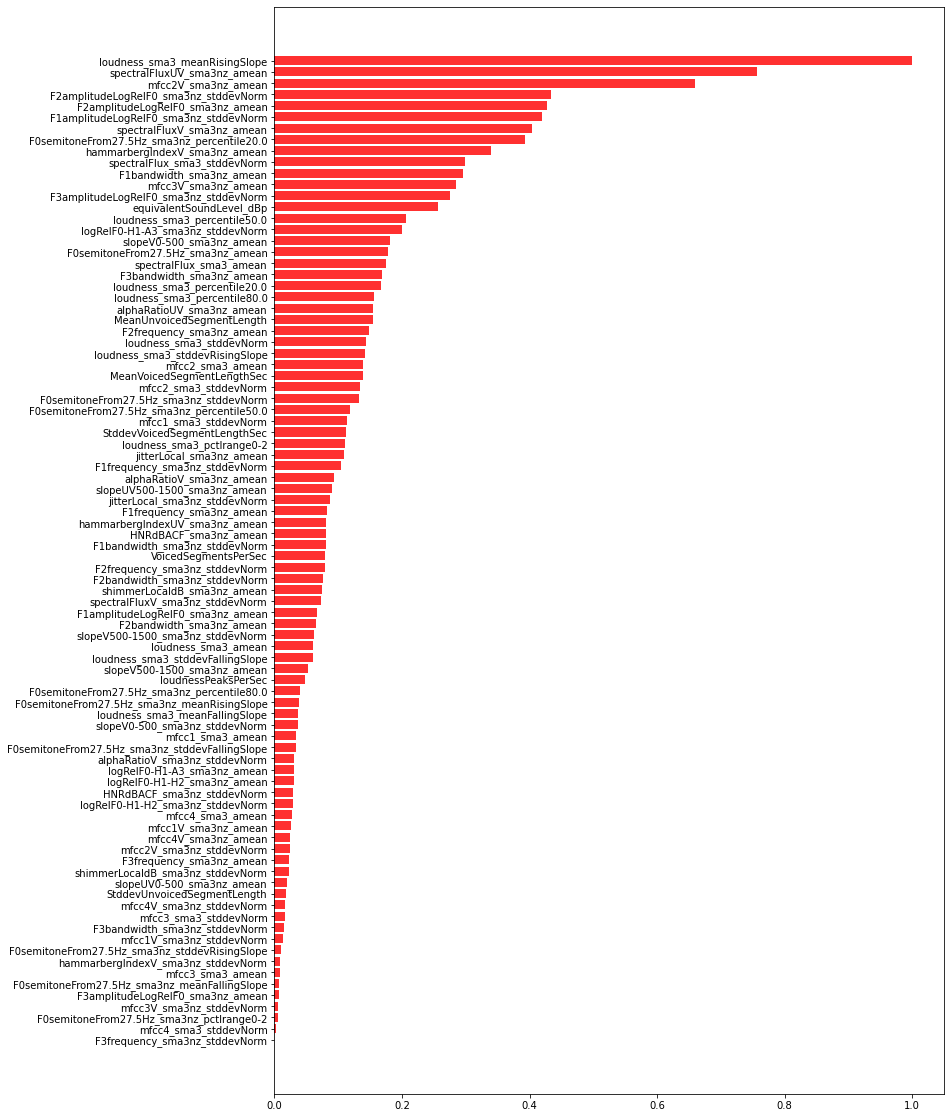

In [ ]:
coef_svm_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color)
print('SVM')


['spectralFlux_sma3_stddevNorm', 'hammarbergIndexV_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'spectralFluxV_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_amean', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean', 'spectralFluxUV_sma3nz_amean', 'loudness_sma3_meanRisingSlope']
SVM


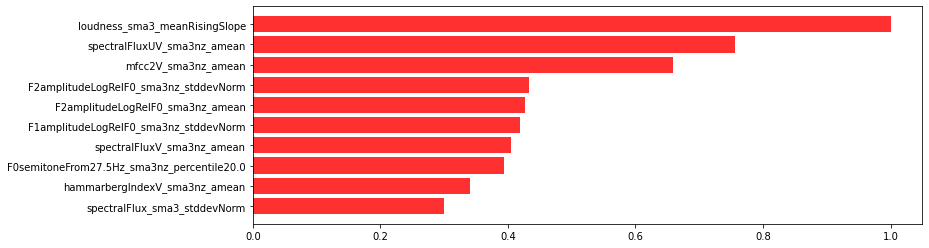

In [ ]:
coef_svm_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color, top_ten=True)
print('SVM')


### Methd 2c: Random Forest Classifier

In [ ]:

def random_forest_plot(labeled_array, label_list, feature_names, color, top_ten=False, plot=True):

  classifier = RandomForestClassifier()

  avg_importance = np.zeros((10, 88))
  for i in range(10):
    classifier.fit(labeled_arrays[model], label_lists[model])
    importance = classifier.feature_importances_
    avg_importance[i] = importance
  importance = np.mean(avg_importance, axis=0)

  actual_importance = importance
  sorted_importance = sorted(importance)
  sorted_feature_names = []
  for imp_val in sorted_importance:
    for i in range(len(actual_importance)):
      if actual_importance[i] == imp_val:
        sorted_feature_names.append(feature_names[i])
        break
  # print(sorted_feature_names)
  # print(len(sorted_feature_names))
  # print(egemaps_feature_names)
  # print(len(egemaps_feature_names))
  if plot==True:
    if (top_ten==True):
      fig, ax = plt.subplots(figsize=(12, 4))
      bars = ax.barh(sorted_feature_names[-10:], sorted_importance[-10:], color=color)
      print(sorted_feature_names[-10:])
    else:
      fig, ax = plt.subplots(figsize=(12, 20))
      bars = ax.barh(sorted_feature_names, sorted_importance, color=color)

  return importance


RANDOM FOREST


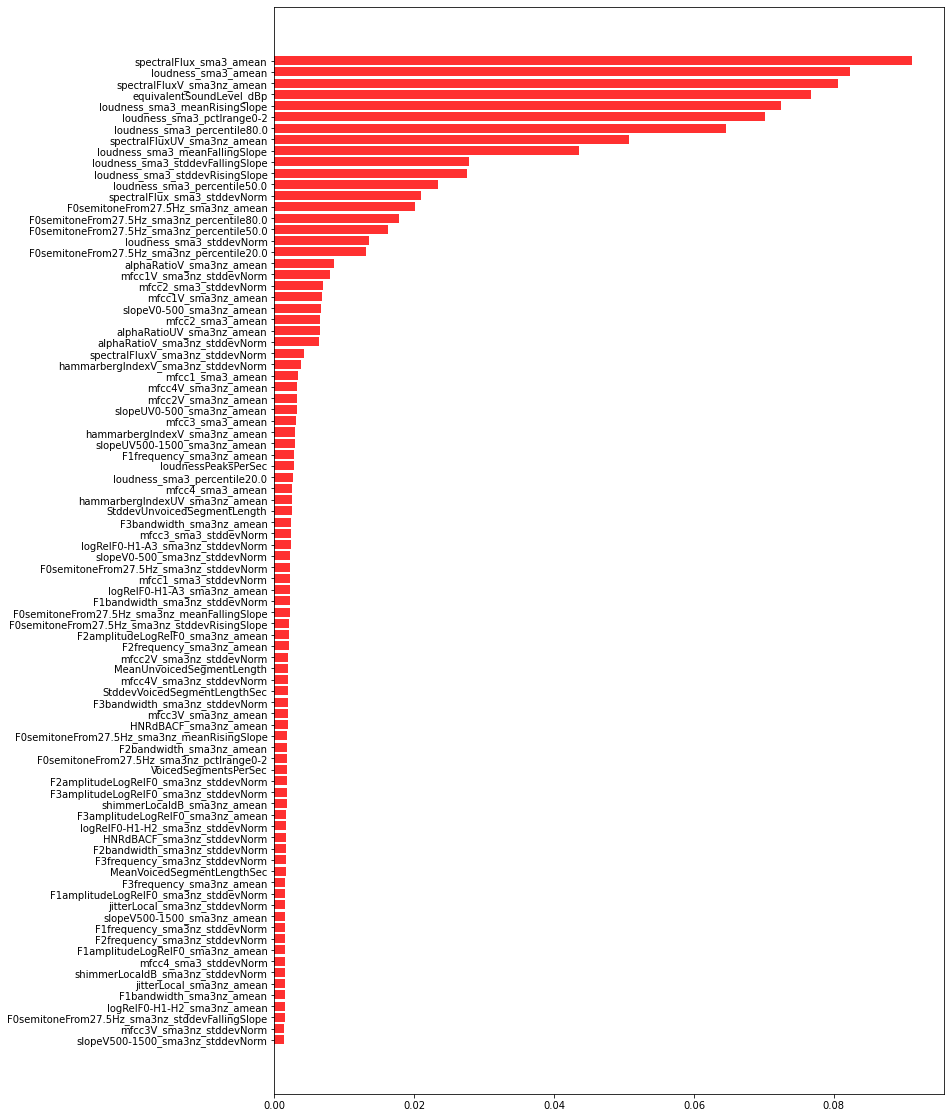

In [ ]:
random_forest_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color)
print('RANDOM FOREST')


['loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'spectralFluxUV_sma3nz_amean', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_amean', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_percentile80.0', 'equivalentSoundLevel_dBp', 'spectralFlux_sma3_amean', 'spectralFluxV_sma3nz_amean']
RANDOM FOREST


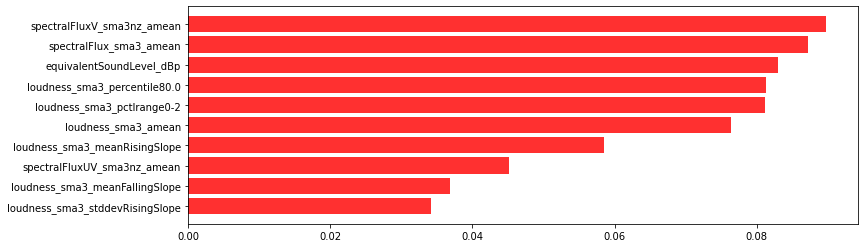

In [ ]:
random_forest_plot(labeled_arrays[model], label_lists[model], feature_names = egemaps_feature_names, color=color, top_ten=True)
print('RANDOM FOREST')


### Method 2: Combined Standard Methods

In [ ]:
def combined_feature_rank(labeled_array, label_list, labeled_speakers_list, feature_names, color, emotion_list = [], top_ten=False):

  logreg_imp = coef_logreg_plot(labeled_array, label_list, feature_names=feature_names, color=color, top_ten=top_ten, plot=False)
  logreg_recall = pipeline(labeled_array, labeled_speakers_list, label_list, classification_model='logreg')

  svm_imp = coef_svm_plot(labeled_array, label_list, feature_names=feature_names, color=color, top_ten=top_ten, plot=False)
  svm_recall = pipeline(labeled_array, labeled_speakers_list, label_list, classification_model='svm')

  rf_imp = random_forest_plot(labeled_array, label_list, feature_names=feature_names, color=color, top_ten=top_ten, plot=False)
  rf_recall = pipeline(labeled_array, labeled_speakers_list, label_list, classification_model='rf')

  combined_importance = (logreg_recall*logreg_imp + svm_recall*svm_imp + rf_recall*rf_imp)/(logreg_recall+svm_recall+rf_recall)

  actual_importance = combined_importance
  sorted_importance = sorted(combined_importance)
  sorted_feature_names = []
  for imp_val in sorted_importance:
    for i in range(len(actual_importance)):
      if actual_importance[i] == imp_val:
        sorted_feature_names.append(feature_names[i])
        break

  if (top_ten==True):
    fig, ax = plt.subplots(figsize=(12, 4))
    bars = ax.barh(sorted_feature_names[-10:], sorted_importance[-10:], color=color)
    print(sorted_feature_names[-10:])
  else:
    fig, ax = plt.subplots(figsize=(12, 20))
    bars = ax.barh(sorted_feature_names, sorted_importance, color=color)

  return combined_importance


recall_macro on test_set: 0.9444148936170212
recall_macro on test_set: 0.9568800764452938
recall_macro on test_set: 0.9421440073613987
COMBINED STANDARD METHODS


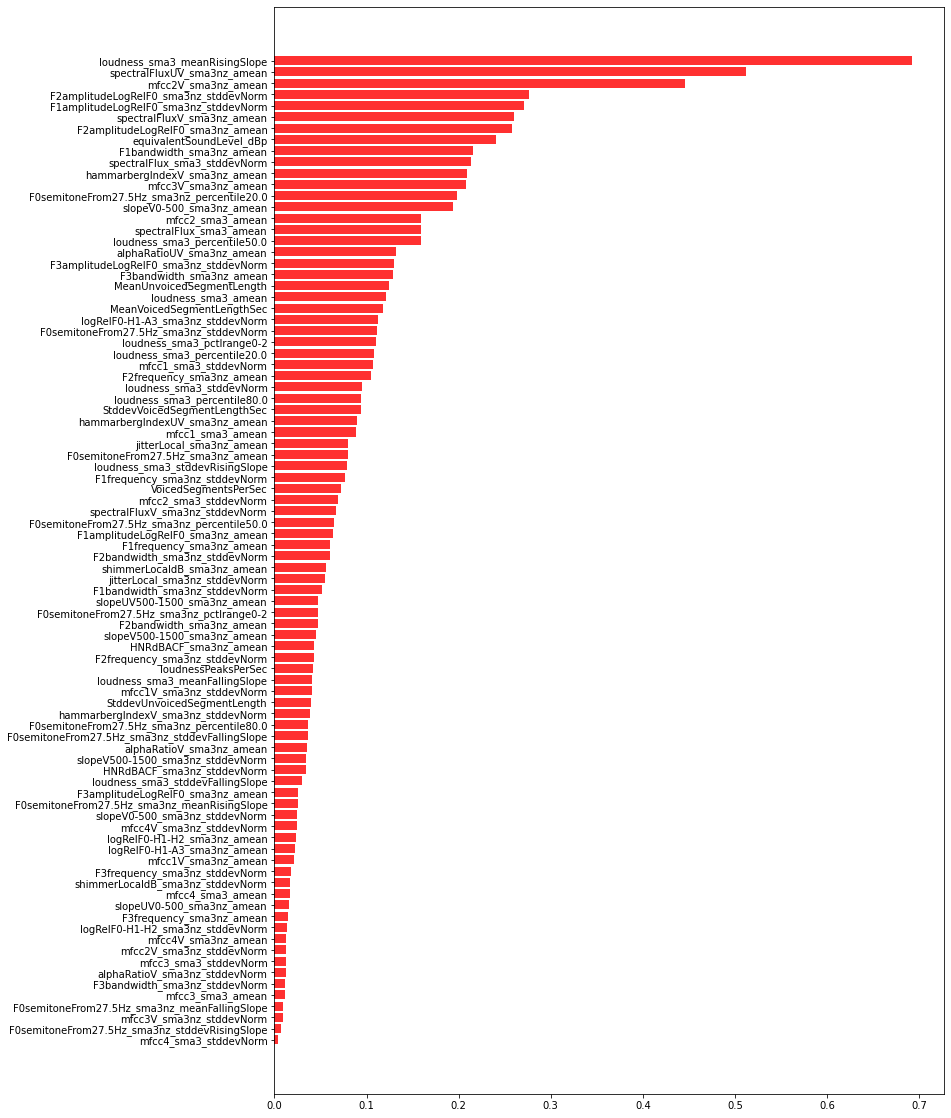

In [ ]:
combined_feature_rank(labeled_arrays[model], label_lists[model], labeled_speakers_list, feature_names = egemaps_feature_names, color=color, top_ten=False)
print('COMBINED STANDARD METHODS')


recall_macro on test_set: 0.9442239858906526
recall_macro on test_set: 0.9489369390084668
recall_macro on test_set: 0.9520247021047704
['spectralFlux_sma3_stddevNorm', 'F1bandwidth_sma3nz_amean', 'equivalentSoundLevel_dBp', 'F2amplitudeLogRelF0_sma3nz_amean', 'spectralFluxV_sma3nz_amean', 'F1amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'mfcc2V_sma3nz_amean', 'spectralFluxUV_sma3nz_amean', 'loudness_sma3_meanRisingSlope']
COMBINED STANDARD METHODS


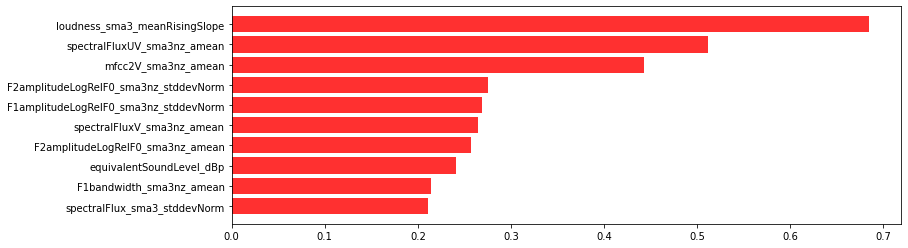

In [ ]:
combined_feature_rank(labeled_arrays[model], label_lists[model], labeled_speakers_list, feature_names = egemaps_feature_names, color=color, top_ten=True)
print('COMBINED STANDARD METHODS')
